<a href="https://colab.research.google.com/github/pcarbomestre/SAR-VesselDetection-FisheriesMonitoring/blob/main/baseline_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Load libraries

The virtual machines used in Colab for the runtimes are ephemeral, so some libraries not preinstalled in Colab environment have to be installed each time we open the notebook. More information about Colab [here](https://colab.research.google.com/github/tensorflow/workshops/blob/master/extras/amld/notebooks/solutions/0_colab.ipynb#scrollTo=fPP3Zw5iV2DP).

Detectron2 is a library that provides state-of-the-art detection and segmentation algorithms. It is not installed by default in the Colab environmebt so we have to install it each time we open a session.

More information about it at https://github.com/facebookresearch/detectron2.

In [ ]:
# Install detectron2:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'
exit(0) # After installation restart Colab's runtime.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-7pp09nvm
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-7pp09nvm
  Resolved https://github.com/facebookresearch/detectron2.git to commit 4e447553eb32b6e3784df0b8fca286935107b2fd
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 45.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 15.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for detectron2: filena

Detectron2 is built on top of PyTorch. Therefore, it requires PyTorch to be imported in order to run it. Beside, we will load all detecron2 utilities and other commmon libraries we are going to use.

In [ ]:
import yaml
import torch, torchvision

# Detectron2
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from google.colab.patches import cv2_imshow

We also need to connect to our Google Drive accoung where we have stored our datasets, and where we are going to save our outputs.

In [ ]:
# Mount Google Drive (Import files from Google Drive in Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Registration of the custom dataset to detectron2

Retrieve previously created datasets compatible with detectron 2

In [ ]:
datasets_path = '/content/drive/Shareddrives/ssdd_pcarbomestre/SSDD_pcarbomestre_2.0/data/datasets/'

# Function that retrieves a standard dataset compatible with detectron2
def get_dict(type):
  """ Returns a list[dict] containing information about the dataset """
  import pickle
  root = datasets_path + type + '/'
  with open(root + "standardDict.pkl", "rb") as input_file:
    return pickle.load(input_file)

The code snippet registers a dataset with Detectron2 by creating a data catalog and setting metadata for the dataset.

In [ ]:
pre = 'ssdd_'

# Register
DatasetCatalog.clear()
for d in ["train", "test", "test_offshore", "test_inshore"]:
    DatasetCatalog.register(pre + d, lambda d=d: get_dict(d))
    MetadataCatalog.get(pre + d).set(thing_classes=["ship"])

Store metadata for each dataset.

In [ ]:
# metadata instances
train_metadata = MetadataCatalog.get(pre + 'train')
test_metadata = MetadataCatalog.get(pre + 'test')
test_offshore_metadata = MetadataCatalog.get(pre + 'test_offshore')
test_inshore_metadata = MetadataCatalog.get(pre + 'test_inshore')

# Training model

Define the output directory where the model output will be generated.

In [ ]:
%cd /content/drive/Shareddrives/ssdd_pcarbomestre/SSDD_pcarbomestre_2.0/output
output = '//content/drive/Shareddrives/ssdd_pcarbomestre/SSDD_pcarbomestre_2.0/output/'
model_name = "./ModelOutput/faster_rcnn_R_101_FPN_3x_26000iter"

/content/drive/Shareddrives/ssdd_pcarbomestre/SSDD_pcarbomestre_2.0/output


The following code sets up the configuration for the Faster R-CNN object detection model using a predefined COCO dataset architecture and our custom dataset, defining various hyperparameters such as the learning rate, batch size, number of classes, and number of iterations for training the model. Detectron configuration information [here](https://detectron2.readthedocs.io/en/latest/modules/config.html).

You can find more information about the Detectron2 Model Zoo [here](https://github.com/facebookresearch/detectron2/tree/master/configs/COCO-Detection).

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = (pre + "train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")  # Training initializes from a pretrained model on zoo
cfg.SOLVER.IMS_PER_BATCH = 2
# Lowering the learning rate can also help prevent overfitting to the training data by encouraging the model
# to learn more generalizable features that work well on new, unseen data.
cfg.SOLVER.BASE_LR = 0.00025 # default is 0.001
cfg.SOLVER.MAX_ITER = 26000 # final number of iterations choosen after trial and error
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # default value for Detectron 2
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS = False # allows training images without annotations (in our case these should have been removed)

# cfg.SOLVER.MOMENTUM = 0.9 # default value
# cfg.SOLVER.WEIGHT_DECAY = 0.0001 # default value
# cfg.MODEL.DEVICE='cpu' # if you want to run it with the CPU instead of GPU

Assing the output path defined before to the model configuration, and create the directory.

In [ ]:
cfg.OUTPUT_DIR = model_name
cfg.OUTPUT_DIR

'./ModelOutput/faster_rcnn_R_101_FPN_3x_26000iter'

In [ ]:
# RUN ONLY ONCE
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [ ]:
assert False # Break the execution here if you run all the chunks at once

Execute the training

In [ ]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)

In [ ]:
trainer.train()

[04/18 01:20:26 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f6e8b1.pkl: 243MB [00:00, 246MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[04/18 01:20:33 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[04/18 01:20:50 d2.utils.events]:  eta: 4:04:36  iter: 19  total_loss: 1.953  loss_cls: 0.7375  loss_box_reg: 0.07749  loss_rpn_cls: 0.9433  loss_rpn_loc: 0.1119    time: 0.5650  last_time: 0.5663  data_time: 0.1704  last_data_time: 0.1475   lr: 4.9953e-06  max_mem: 2378M
[04/18 01:21:04 d2.utils.events]:  eta: 3:50:34  iter: 39  total_loss: 1.326  loss_cls: 0.6465  loss_box_reg: 0.1087  loss_rpn_cls: 0.4982  loss_rpn_loc: 0.1345    time: 0.5498  last_time: 0.5348  data_time: 0.1281  last_data_time: 0.1791   lr: 9.9902e-06  max_mem: 2378M
[04/18 01:21:15 d2.utils.events]:  eta: 3:50:23  iter: 59  total_loss: 0.8431  loss_cls: 0.4581  loss_box_reg: 0.1044  loss_rpn_cls: 0.0368  loss_rpn_loc: 0.1208    time: 0.5487  last_time: 0.5042  data_time: 0.1211  last_data_time: 0.1569   lr: 1.4985e-05  max_mem: 2378M
[04/18 01:21:26 d2.utils.events]:  eta: 3:48:51  iter: 79  total_loss: 0.5396  loss_cls: 0.2923  loss_box_reg: 0.09155  loss_rpn_cls: 0.01783  loss_rpn_loc: 0.03985    time: 0.5468  

# Training evaluation

### Evaluate training outputs

In [ ]:
%cd /content/drive/Shareddrives/ssdd_pcarbomestre/SSDD_pcarbomestre_2.0/output
output = '//content/drive/Shareddrives/ssdd_pcarbomestre/SSDD_pcarbomestre_2.0/output/'
model_name = "./ModelOutput/faster_rcnn_R_101_FPN_3x_26000iter"
cfg.OUTPUT_DIR = model_name
experiment_folder = cfg.OUTPUT_DIR

/content/drive/Shareddrives/ssdd_pcarbomestre/SSDD_pcarbomestre_2.0/output


In [ ]:
def load_json_arr(json_path):

    '''Auxiliary function that transforms the input .json file to a list of dicts.

    Args:
        json_path (str): Output folder that was used during training.
    '''

    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

def plot_train_val_loss(experiment_folder):

    '''Plots total and validation losses based on the "metrics.json" file generated
    in training. The total (training) loss is calculated every 20 iterations (default
    step in detectron2 library for loss calculation) and validation loss is calculated
    every cfg.TEST.EVAL_PERIOD iterations.

    Args:
        experiment_folder (str): Output folder that was used during training.
    '''

    experiment_metrics = load_json_arr(experiment_folder + '/metrics.json')

    plt.figure(figsize=(16,8))

    # Plot total loss.
    plt.plot(
        [x['iteration'] for x in experiment_metrics if 'total_loss' in x],
        [x['total_loss'] for x in experiment_metrics if 'total_loss' in x],
        label="total_loss")

    # Plot validation loss curve.
    xs = [x['iteration'] for x in experiment_metrics if 'validation_loss' in x]
    ys = [x['validation_loss'] for x in experiment_metrics if 'validation_loss' in x]
    if ys!=[]: plt.plot(xs, ys, c='red', label="validation_loss")

    # Plot validation loss points.
    plt.scatter(xs, ys, marker='*', zorder=10, c='black')

    # Plot labels.
    for x_pos, y_pos in zip(xs, ys):
        label = str(round(y_pos,3))
        while (len(label)<5): label += '0'
        plt.text(x_pos, y_pos+0.05, s=label)

    # Plot properties
    plt.legend(loc='upper right')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.grid()

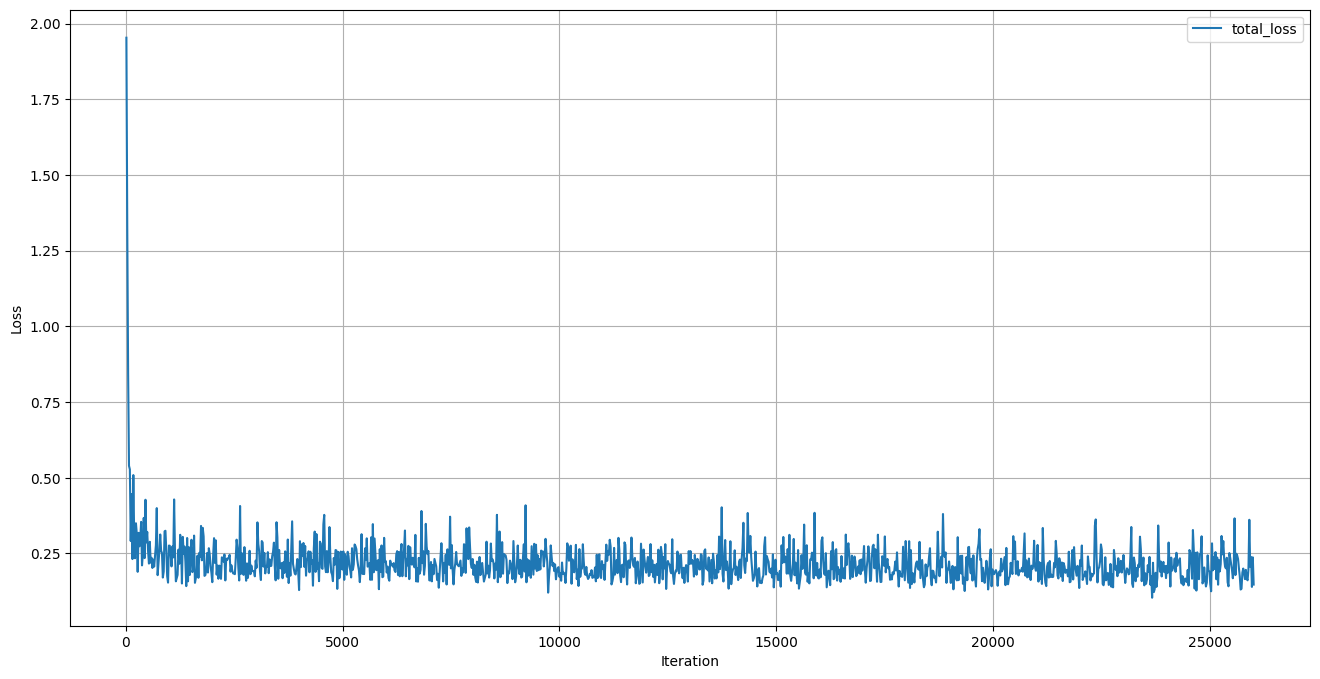

In [ ]:
plot_train_val_loss(experiment_folder)

In [ ]:
def plot_all_losses(experiment_folder, y_log_scale=True, trendlines=True):

    '''Plots the 4 different losses (RPN+ROI Heads) of the Faster-RCNN network
    based on the "metrics.json" file.

    Args:
        experiment_folder (str): Output folder that was used during training.
        y_log_scale (bool): If y-axis is in log scale.
        trendlines (bool): Plot the corresponding polynomial trendlines of the losses.
    '''

    experiment_metrics = load_json_arr(experiment_folder + '/metrics.json')
    plt.figure(figsize=(16,8))

    losses = ["loss_box_reg", "loss_cls", "loss_rpn_cls", "loss_rpn_loc"]

    # Plot loss.
    for loss in losses:

        # Plot original line.
        xs = [x['iteration'] for x in experiment_metrics if loss in x]
        ys = [x[loss] for x in experiment_metrics if loss in x]
        order = np.argsort(xs)
        p = plt.plot(xs, ys, "-", label=loss, linewidth = 1)

        if trendlines:

            # Plot polynomial trendline.
            z = np.polyfit(np.array(xs)[order.astype(int)],
                     np.array(ys)[order.astype(int)], 2)
            poly = np.poly1d(z)
            plt.plot(np.array(xs)[order.astype(int)],
                     poly(np.array(xs)[order.astype(int)]),
                     color = p[0].get_color(), linewidth=1.5)

    # Plot properties
    plt.legend(loc='upper right')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    if y_log_scale: plt.yscale('log')
    plt.grid()

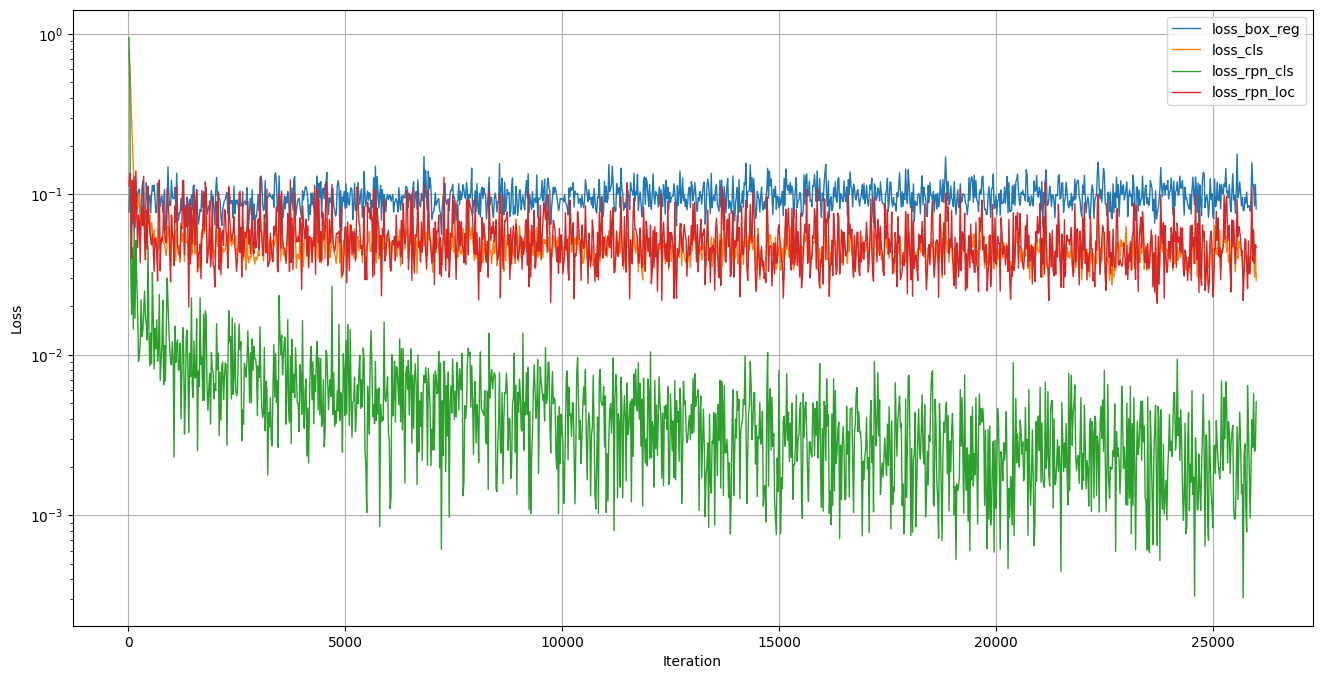

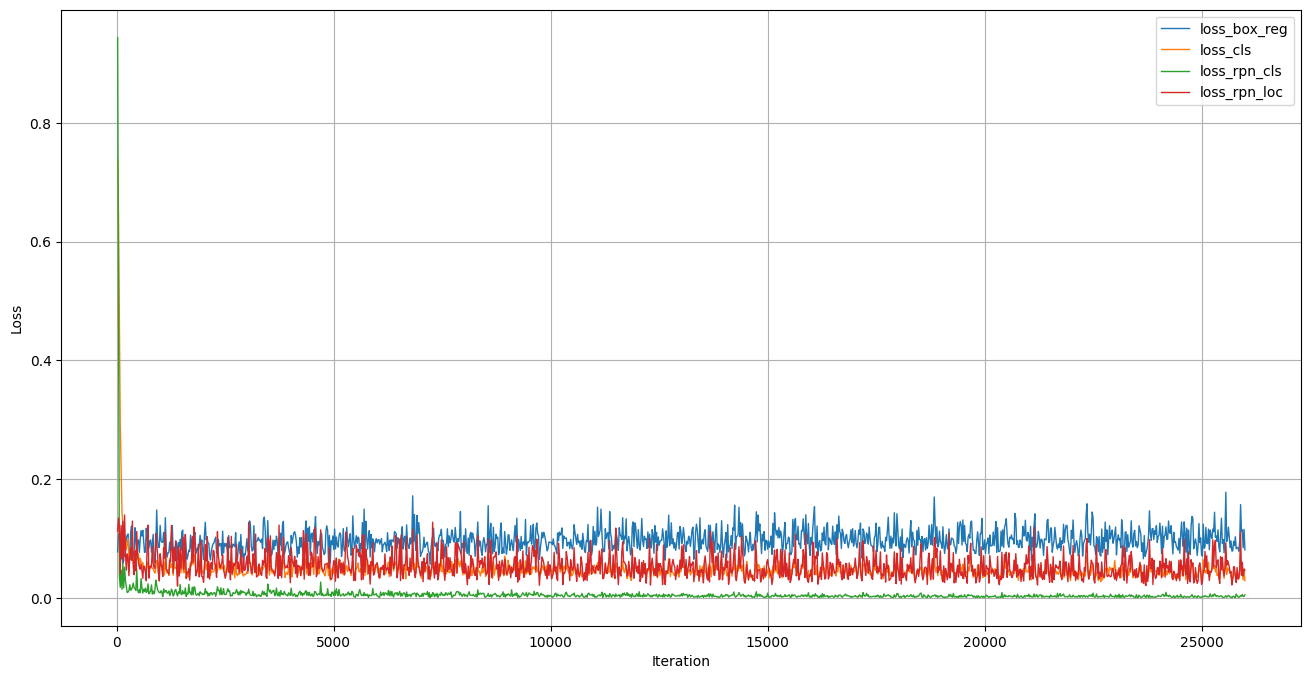

In [ ]:
%matplotlib inline
plot_all_losses(experiment_folder, True, False)
plot_all_losses(experiment_folder, False, False)

In [ ]:
def plot_other_info(experiment_folder):

    '''Plots foreground/ backround accuracy, number of foreground and backround
    samples as well as the numbers of positive and negative anchors existing in a
    batch.

    Args:
        experiment_folder (str): Output folder that was used during training.
    '''

    experiment_metrics = load_json_arr(experiment_folder + '/metrics.json')

    mtrics = ["fast_rcnn/cls_accuracy",
              "fast_rcnn/false_negative",
              "fast_rcnn/fg_cls_accuracy",
              "roi_head/num_bg_samples",
              "roi_head/num_fg_samples",
              "rpn/num_neg_anchors",
              "rpn/num_pos_anchors"]

    # Plots.
    fig, ax1 = plt.subplots(figsize=(16,8))
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    cmaplist = plt.get_cmap('Dark2').colors

    for i, mtric in enumerate(mtrics):

        xs = [x['iteration'] for x in experiment_metrics if mtric in x]
        ys = [x[mtric] for x in experiment_metrics if mtric in x]

        # Label properties.
        mean = np.array(ys).mean()
        label = str(round(mean, 3))

        # Select in which axis you want to plot each metric.
        if mtric in mtrics[:3]:
            p = ax1.plot(xs, ys, label=mtric, color = cmaplist[i], linewidth=1)
            text_color = p[0].get_color()
            ax1.text(np.array(xs).mean()+500*i, mean, s=label, color=text_color, zorder=6,
                     size=14, path_effects=[pe.withStroke(linewidth=2, foreground="black")])
        else:
            p = ax2.plot(xs, ys, label=mtric, color = cmaplist[i], linewidth=1)
            text_color = p[0].get_color()
            ax2.text(np.array(xs).mean()+500*i, mean, s=label, color=text_color, zorder=6,
                     size=14, path_effects=[pe.withStroke(linewidth=1, foreground="black")])

    # Axis properties
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('FG+BG Accuracy')
    ax2.set_ylabel('Number of FG+BG Samples and Positive/Negative Anchors')
    ax1.grid()

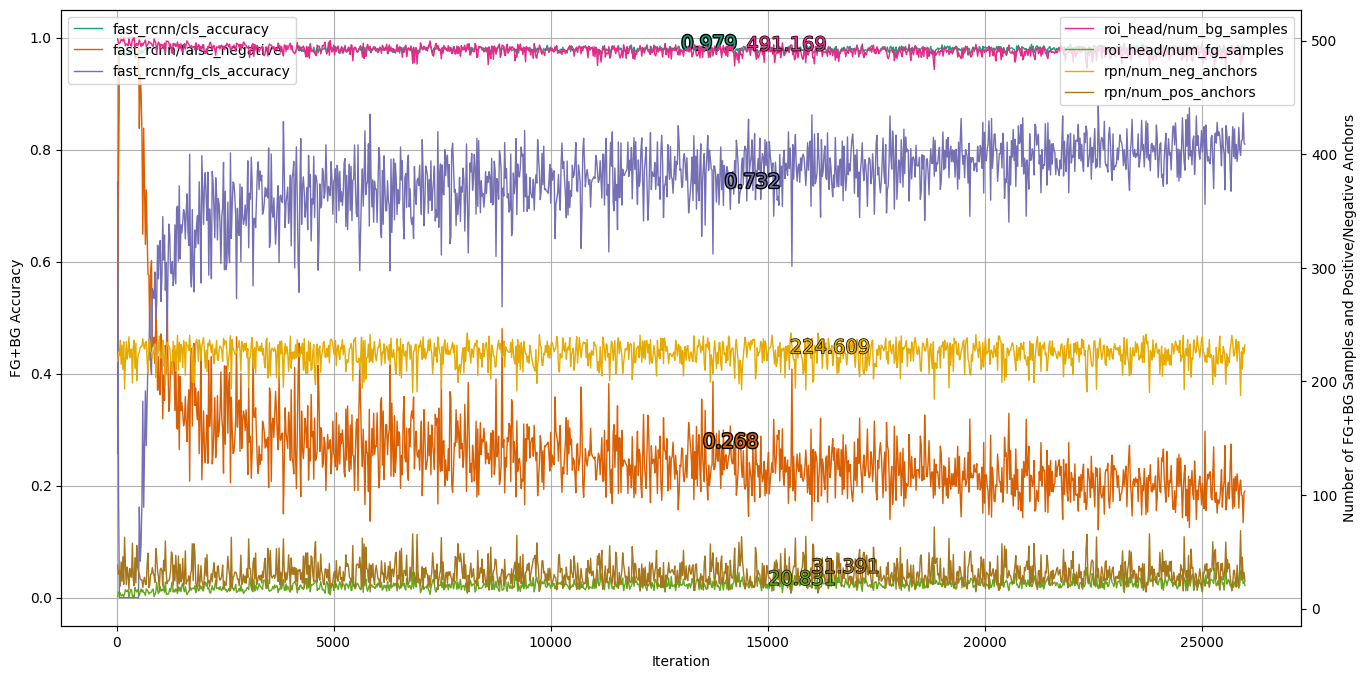

In [ ]:
plot_other_info(experiment_folder)

Alternatively, we can represent de metrics using Tensorboard

In [ ]:
# Look at training curves in tensorboard:
%cd ModelOutput/
%load_ext tensorboard
%tensorboard --logdir faster_rcnn_test
%cd ..

### Evaluate performance based on original model setup


We will evaluate its performance using AP metrics implemented in the COCO API.This can only be executed in the same Colab session when the model was trained. This just give us a general idea of the trained model performance over the test dataset. However, we will evaluate its performance on another notebook following Zhang et al., evaluation criteria.

In [ ]:
# test
evaluator = COCOEvaluator('ssdd_test', ('bbox',), False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, 'ssdd_test')

print(inference_on_dataset(trainer.model, val_loader, evaluator))

[04/18 04:41:05 d2.evaluation.coco_evaluation]: Trying to convert 'ssdd_test' to COCO format ...
[04/18 04:41:05 d2.data.datasets.coco]: Converting annotations of dataset 'ssdd_test' to COCO format ...)
[04/18 04:41:11 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[04/18 04:41:12 d2.data.datasets.coco]: Conversion finished, #images: 736, #annotations: 2378
[04/18 04:41:12 d2.data.datasets.coco]: Caching COCO format annotations at './ModelOutput/faster_rcnn_R_101_FPN_3x_26000iter/ssdd_test_coco_format.json' ...
[04/18 04:41:12 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    ship    | 2378         |
|            |              |
[04/18 04:41:12 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/18 04:41:12 d2.data.common]: Serializing the dataset using: <class 'detectron2.